In [1]:
from fraud_predictor.preprocessors.preprocessing import load_df, drop_unnecessary_columns 
from fraud_predictor.merging.merging_df import load_df2, rename_columns, rename_values, add_column_by_merge, load_df3, gdp_capita_columns_keep
from fraud_predictor.features.features_creation import transform_to_datetime_type, create_time_columns, categorize_hour_column, drop_redundant_columns, create_channel_usage, create_interaction_by_category, create_payment_safety
from fraud_predictor.model.model_and_metrics import split_data, convert_object_to_category, tune_lightgbm, train_optimized_lightgbm, predict, predict_proba, calculate_accuracy, calculate_roc_auc, calculate_f1, plot_feature_importance

In [2]:
# Load the main df 
df = load_df()              

In [3]:
# Sample 10,000 observations from the original df 
#df = sample_data(df) 

## Since the original dataset is too large to upload to github, we only uploaded the sample df and our analysis will start there.
## However, this line of code was used when working with the original dataset.

In [4]:
# Drop unrelevant columns for the prediction 
df = drop_unnecessary_columns(df)

In [5]:
# Import the second dataframe, which contains the gdp column 
df2 = load_df2('gdp_country.csv')

In [6]:
# Import the third dataframe, which contains gdp per capita and drop columns 
df3 = load_df3('gdp_per_capita.csv')

In [7]:
# Restructure the gdp per capita dataframe to keep only necessary columns
df3 = gdp_capita_columns_keep(df3)

In [8]:
# Rename columns in df2 and df3 in order to match with df's columns 
rename_mapping = {'Country Name': 'country', '2023': 'GDP'}
df2 = rename_columns(df2, rename_mapping)

rename_mapping = {'Country Name': 'country', '2023': 'GDP_per_capita'}
df3 = rename_columns(df3, rename_mapping)

In [9]:
# Manually adjust the mismatch between some countries' names in the three dataframes before merging 
rename_mapping = {'country': {'usa': 'united states', 'uk': 'united kingdom', 'russia': 'russian federation'}}
df = rename_values(df, rename_mapping)

In [10]:
# Add the gdp and gdp_per_capita column to the main dataframe
df = add_column_by_merge(df, df2, merge_on=['country'], columns_to_merge=['GDP'], how='left')
df = add_column_by_merge(df, df3, merge_on=['country'], columns_to_merge=['GDP_per_capita'], how='left')

In [11]:
# Transform the column "timestamp" into type "datetime" to allow the necessary manipulations
df = transform_to_datetime_type(df)

In [12]:
# From the "timestamp" column, create three columns for: hour, day of the month and month 
df = create_time_columns(df)

In [13]:
# From the column "transaction_hour" create a categorical column with moments of the day
df = categorize_hour_column(df)

In [14]:
# Drop "timestamp" and "transaction_hour" since we have created other columns that give the same type of 
# information but in a more efficient way
columns_to_drop = ['timestamp', 'transaction_hour']
df = drop_redundant_columns(df, columns_to_drop)

In [15]:
# Create a column that indicates frequency with which each customer makes purchases through one of the three 
# channels (web, mobile, pos). 
df = create_channel_usage(df)

In [16]:
# Create an interaction between "category" and "amount" to normalize the amount spent for each category 
df = create_interaction_by_category(df, 
                                    col1='amount', 
                                    col2='merchant_category', 
                                    new_col_name='value_by_category')

In [17]:
# Create a column that ranks the payment methods depending on their level of safety 
device_mapping = {
    'Edge': 1,
    'Chrome': 1,
    'Safari': 1,
    'Firefox': 1,
    'iOS App': 2,
    'Android App': 2,
    'NFC Payment': 3,
    'Chip Reader': 4,
    'Magnetic Stripe': 4
}
df = create_payment_safety(df, device_col='device', safety_col='payment_safety', device_mapping=device_mapping)

In [18]:
# Divide between train and test 
X_train, X_test, y_train, y_test = split_data(df)

In [19]:
# Convert columns of type 'object' into pandas Categoricals
X_train, X_test = convert_object_to_category(X_train, X_test)

In [20]:
# Hyperparameter tuning
best_params, _ = tune_lightgbm(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 1274, number of negative: 5126
[LightGBM] [Info] Number of positive: 1274, number of negative: 5126
[LightGBM] [Info] Number of positive: 1274, number of negative: 5126
[LightGBM] [Info] Number of positive: 1273, number of negative: 5127
[LightGBM] [Info] Number of positive: 1273, number of negative: 5127
[LightGBM] [Info] Number of positive: 1273, number of negative: 5127
[LightGBM] [Info] Number of positive: 1273, number of negative: 5127
[LightGBM] [Info] Number of positive: 1274, number of negative: 5126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_row_wise=true` to remove the overhead

In [21]:
# Train the optimized LightGBM boosting 
model = train_optimized_lightgbm(X_train, y_train, best_params)

[LightGBM] [Info] Number of positive: 1592, number of negative: 6408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199000 -> initscore=-1.392556
[LightGBM] [Info] Start training from score -1.392556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [22]:
# Make predictions using the trained model
y_pred = predict(model, X_test)

In [23]:
# Predict probabilities 
y_proba = predict_proba(model, X_test)

In [24]:
# Compute the accuracy 
accuracy = calculate_accuracy(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9655


In [25]:
# Compute ROC_AUC score 
roc_auc = calculate_roc_auc(model, X_test, y_test)
print('ROC_AUC score:', roc_auc)

ROC_AUC score: 0.9914459940150189


In [26]:
# Compute F1 score 
f1 = calculate_f1(y_test, y_pred)
print("Calculated F1 score:", f1)


Calculated F1 score: 0.9652490760883184


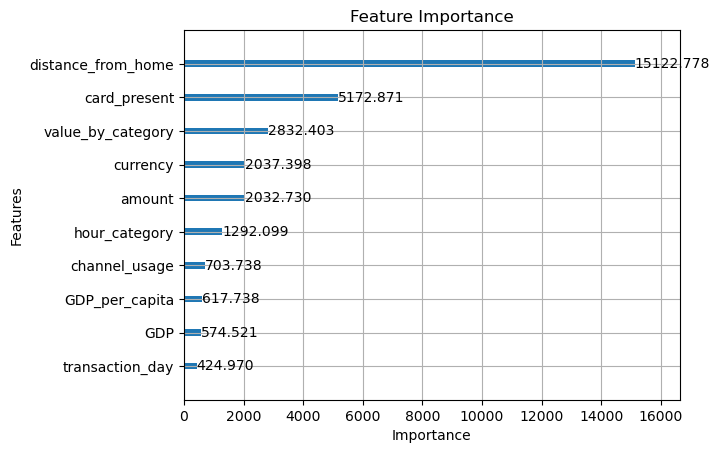

In [27]:
# Plot the features importance 
plot_feature_importance(model)